In [2]:
import tensorflow as tf
import sys, imageio, os
sys.path.append("/Users/kai/Downloads/graduation/AMFtrack")
from amftrack.util.sys import storage_path
from amftrack.ml.width.data_augmentation import data_augmentation, data_preparation
from tensorflow import keras
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import numpy as np
import keras_tuner as kt

In [3]:
tf.config.run_functions_eagerly(True)

In [4]:
path = os.path.join(storage_path,"single_focus_-0.3_train")
im_path = os.path.join(path, "slices.png")
label_path = os.path.join(path, "labels.npy")
im = imageio.imread(im_path)
with open(label_path, "rb") as f:
    label = np.load(f)
label = np.expand_dims(label,1)
np.random.seed(0)
n_label = np.random.permutation(label.shape[0])
print('Data Type: %s' % im.dtype)
print('Min: %.3f, Max: %.3f' % (im.min(), im.max()))
X_train, X_test, y_train, y_test = train_test_split(im,label,test_size=0.4, random_state=42,shuffle=True)

Data Type: uint8
Min: 117.000, Max: 198.000


In [63]:
# light one
def build_model_CNN(hp):
    """
    need to check the input size
    need to check dropout layer
    need to check L1,L2
    need to check the distribution of the data to make sure MAE or MSE
    https://blog.yeshuanova.com/2018/02/depthwise-separable-convolution/ 
    if work need to think about DepthwiseConv1D to make it smaller
    """
    input_size = hp.Fixed("input", 120)
    model = keras.Sequential()
    model.add(keras.layers.Rescaling(1 / 127.5, input_shape=(input_size,1),offset=-1))
    # stride = hp.Int(f"Strides",min_value=1,max_value=4,step=1)
    for i in range(hp.Int("num_conv_layers", 1, 3,default=2)):
        # For convolution layer
        model.add(keras.layers.Conv1D(
            filters= hp.Int(f"filters_{i+1}",min_value=32,max_value=256,step=32),
            kernel_size = hp.Int(f"kernal_size_{i+1}",min_value=5,max_value=20,sampling = "log"),
            activation="relu",
            name=f"conv_{i+1}",
            kernel_regularizer=keras.regularizers.L1(hp.Float("kernel_regulizer", min_value=1e-5, max_value=1e-1,sampling = "log")),
            activity_regularizer=keras.regularizers.L1(hp.Float("activity_regulizer", min_value=1e-5, max_value=1e-1,sampling = "log")),
            bias_regularizer = keras.regularizers.L1(hp.Float("activity_regulizer", min_value=1e-5, max_value=1e-1,sampling = "log"))))
        # For pooling layer
        hp_pooling = hp.Choice(f'pooling_{i}', values=["MP", "AP"])
        if hp_pooling == "MP":
            model.add(keras.layers.MaxPooling1D(2))
        if hp_pooling == "AP":
            model.add(keras.layers.AveragePooling1D(2))
        # if hp_pooling == "GMP":
        #     model.add(keras.layers.GlobalMaxPooling1D())
        # if hp_pooling == "GAP":
        #     model.add(keras.layers.GlobalAveragePooling1D())
        # https://wandb.ai/authors/ayusht/reports/Batch-Normalization-in-Keras-An-Example--VmlldzoxNzI5NjQ
        # For batch normalization
        if hp.Boolean("batch_normalization", default=False):
            model.add(keras.layers.BatchNormalization()) 
    model.add(keras.layers.Dropout(hp.Float("Dropout", min_value=0, max_value=0.2,step = 0.1, default = 0.2)))
    model.add(keras.layers.Flatten())
    for j in range(hp.Int("num_dense_layers", 1, 3,default=2)):
        # For dense layer
        model.add(keras.layers.Dense(
            units=hp.Int("dense_size", min_value=8,max_value=256,step=16),activation="relu",
            name=f"dense_{j+1}",
            kernel_regularizer=keras.regularizers.L1(hp.Float("kernel_regulizer", min_value=1e-5, max_value=1e-1,sampling = "log")),
            activity_regularizer=keras.regularizers.L1(hp.Float("activity_regulizer", min_value=1e-5, max_value=1e-1,sampling = "log")),
            bias_regularizer = keras.regularizers.L1(hp.Float("activity_regulizer", min_value=1e-5, max_value=1e-1,sampling = "log"))))
        # The dropout rate is the fraction of the features that are zeroed out; it’s usually set between 0.2 and 0.5. Francois Chollet book
        model.add(keras.layers.Dropout(hp.Float(f"dropout_{i+1}", 0, 0.5, step=0.1, default=0.2)))
    model.add(keras.layers.Dense(units = 1,activation=None,name="output"))
    
    # How to choose optimizer: https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Float("learning_rate", min_value=1e-5, max_value=1e-1, sampling="log",default=1e-3)),
        # https://keras.io/api/losses/regression_losses/
        # MSLE: target value has a spread of values and when predicting a large value
        # MSE: distribution of the target variable is Gaussian
        # MAE: mostly Gaussian, but may have outliers
        loss="mean_squared_error",
        # https://keras.io/api/metrics/regression_metrics/
        # https://towardsdatascience.com/evaluation-metrics-model-selection-in-linear-regression-73c7573208be
        # MSE is more sensitive to outliers than MAE.
        # MAE Not preferred in cases where outliers are prominent.
        metrics="mean_absolute_error")
    return model
hp = kt.HyperParameters()
model_tuning = build_model_CNN(hp)
model_tuning.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 120, 1)            0         
                                                                 
 conv_1 (Conv1D)             (None, 116, 32)           192       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 58, 32)           0         
 1D)                                                             
                                                                 
 conv_2 (Conv1D)             (None, 54, 32)            5152      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 27, 32)           0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 27, 32)           

In [64]:
tuner = kt.RandomSearch(
    build_model_CNN,
    objective="val_mean_absolute_error",
    max_trials=50,
    seed=11,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    overwrite=True,
)

In [66]:
tuner.search(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8)],
)
# 1.4620797634124756
# 1.5012961626052856

Trial 50 Complete [00h 00m 01s]
val_mean_absolute_error: 4.593352317810059

Best val_mean_absolute_error So Far: 1.5100891590118408
Total elapsed time: 00h 09m 18s
INFO:tensorflow:Oracle triggered exit
2022-11-02 22:50:31,202-[INFO]- tensorflow:1 -> Oracle triggered exit


In [85]:
best_CNN_model_light = tuner.get_best_models(1)[0]
tuner.results_summary()

2022-11-02 23:01:49,757-[WARNING]- tensorflow:185 -> Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
2022-11-02 23:01:49,758-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.iter
2022-11-02 23:01:49,758-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_1
2022-11-02 23:01:49,759-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_2
2022-11-02 23:01:49,759-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.decay
2022-11-02 23:01:49,760-[WARNI

In [ ]:
best_CNN_model_light.fit(X_test,y_test)

In [86]:
best_CNN_hp_light = tuner.get_best_hyperparameters(1)[0]
print(best_CNN_hp_light.get_config())

{'space': [{'class_name': 'Fixed', 'config': {'name': 'input', 'conditions': [], 'value': 120}}, {'class_name': 'Int', 'config': {'name': 'num_conv_layers', 'default': 2, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}}, {'class_name': 'Int', 'config': {'name': 'filters_1', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}}, {'class_name': 'Int', 'config': {'name': 'kernal_size_1', 'default': None, 'conditions': [], 'min_value': 5, 'max_value': 20, 'step': 1, 'sampling': 'log'}}, {'class_name': 'Float', 'config': {'name': 'kernel_regulizer', 'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}}, {'class_name': 'Float', 'config': {'name': 'activity_regulizer', 'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}}, {'class_name': 'Choice', 'config': {'name': 'pooling_0', 'default': 'MP', 'conditions': 

In [105]:
import numpy as np
from sklearn.linear_model import LinearRegression
x = np.array(y_test)
y = np.array(predicted)
reg = LinearRegression().fit(x, y)
pre = reg.predict(x)

(2.0, 16.0)

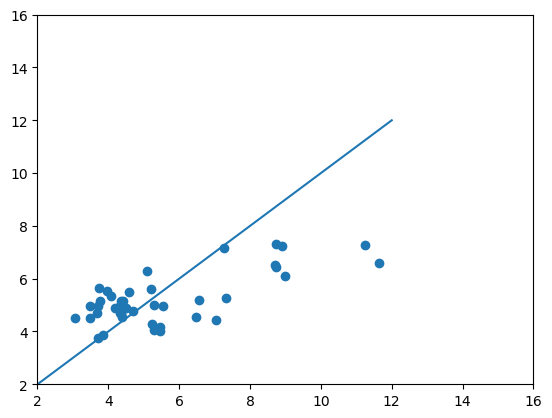

In [110]:
import matplotlib.pyplot as plt
predicted = best_CNN_model_light.predict(X_test)
plt.scatter(y_test, predicted, marker="o")
plt.plot([0, 12], [0, 12])
plt.xlim(2, 16)
plt.ylim(2, 16)

In [95]:
best_CNN_model_light.evaluate(X_test, y_test)

2/2 [==============================] - 0s 20ms/step - loss: 4.7593 - mean_absolute_error: 1.4213


[4.759346008300781, 1.4213130474090576]

In [87]:
# heavy one
def build_model_CNN(hp):
    """
    need to check the input size
    need to check dropout layer
    need to check L1,L2
    need to check the distribution of the data to make sure MAE or MSE
    https://blog.yeshuanova.com/2018/02/depthwise-separable-convolution/ 
    if work need to think about DepthwiseConv1D to make it smaller
    """
    input_size = hp.Fixed("input", 120)
    model = keras.Sequential()
    model.add(keras.layers.Rescaling(1 / 127.5, input_shape=(input_size,1),offset=-1))
    # https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/
    #TODO add stride = hp.Int(f"Strides",min_value=1,max_value=4,step=1)
    for i in range(hp.Int("num_conv_layers", 1, 3,default=2)):
        # For convolution layer
        model.add(keras.layers.Conv1D(
            filters= hp.Int(f"filters_{i+1}",min_value=32,max_value=512,step=32),
            kernel_size = hp.Int(f"kernal_size_{i+1}",min_value=5,max_value=20,sampling = "log"),
            activation="relu",
            name=f"conv_{i+1}",
            kernel_regularizer=keras.regularizers.L1(hp.Float(f"Conv_kernel_regulizer_{i}", min_value=1e-5, max_value=1e-1,sampling = "log")),
            activity_regularizer=keras.regularizers.L1(hp.Float(f"Conv_activity_regulizer_{i}", min_value=1e-5, max_value=1e-1,sampling = "log")),
            bias_regularizer = keras.regularizers.L1(hp.Float(f"Conv_activity_regulizer_{i}", min_value=1e-5, max_value=1e-1,sampling = "log"))))
        # For pooling layer
        hp_pooling = hp.Choice(f'pooling_{i}', values=["MP", "AP"])
        if hp_pooling == "MP":
            model.add(keras.layers.MaxPooling1D(2))
        if hp_pooling == "AP":
            model.add(keras.layers.AveragePooling1D(2))
        # https://wandb.ai/authors/ayusht/reports/Batch-Normalization-in-Keras-An-Example--VmlldzoxNzI5NjQ
        # For batch normalization
        if hp.Boolean("batch_normalization"):
            model.add(keras.layers.BatchNormalization()) 
        model.add(keras.layers.Dropout(hp.Float("Conv_Dropout", min_value=0, max_value=0.2,step = 0.1)))
    model.add(keras.layers.Flatten())
    for j in range(hp.Int("num_dense_layers", 1, 4,default=2)):
        # For dense layer
        model.add(keras.layers.Dense(
            units=hp.Int("dense_size", min_value=32,max_value=512,step=32),activation="relu",
            name=f"dense_{j+1}",
            kernel_regularizer=keras.regularizers.L1(hp.Float(f"dense_kernel_regulizer_{j}", min_value=1e-5, max_value=1e-1,sampling = "log")),
            activity_regularizer=keras.regularizers.L1(hp.Float(f"activity_regulizer_{j}", min_value=1e-5, max_value=1e-1,sampling = "log")),
            bias_regularizer = keras.regularizers.L1(hp.Float(f"activity_regulizer_{j}", min_value=1e-5, max_value=1e-1,sampling = "log"))))
        # The dropout rate is the fraction of the features that are zeroed out; it’s usually set between 0.2 and 0.5. Francois Chollet book
        model.add(keras.layers.Dropout(hp.Float(f"dropout_{i+1}", 0, 0.5, step=0.1, default=0.2)))
    model.add(keras.layers.Dense(units = 1,activation=None,name="output"))
    
    # How to choose optimizer: https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Float("learning_rate", min_value=1e-5, max_value=1e-1, sampling="log",default=1e-3)),
        # https://keras.io/api/losses/regression_losses/
        # MSLE: target value has a spread of values and when predicting a large value
        # MSE: distribution of the target variable is Gaussian
        # MAE: mostly Gaussian, but may have outliers
        loss="mean_squared_error",
        # https://towardsdatascience.com/evaluation-metrics-model-selection-in-linear-regression-73c7573208be
        # MSE is more sensitive to outliers than MAE.
        # MAE Not preferred in cases where outliers are prominent.
        # https://onlinelibrary.wiley.com/doi/full/10.1002/ece3.6618
        # Mean absolute error (MAE), mean bias error (MBE), and mean percent absolute error (MPAE)
        # were the three metrics used to evaluate the performance of the regressors.
        metrics="mean_absolute_error")
    return model

tuner = kt.RandomSearch(
    build_model_CNN,
    objective="val_mean_absolute_error",
    max_trials=50,
    seed=11,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    overwrite=True,
)
tuner.search(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8)],
)

Trial 50 Complete [00h 00m 03s]
val_mean_absolute_error: 2.9412081241607666

Best val_mean_absolute_error So Far: 1.5005043745040894
Total elapsed time: 00h 20m 45s
INFO:tensorflow:Oracle triggered exit
2022-11-02 23:23:20,756-[INFO]- tensorflow:76 -> Oracle triggered exit


In [88]:
best_CNN_model_heavy = tuner.get_best_models(1)[0]
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
input: 120
num_conv_layers: 1
filters_1: 288
kernal_size_1: 8
Conv_kernel_regulizer_0: 0.0006479748676738555
Conv_activity_regulizer_0: 0.0002742518683611044
pooling_0: AP
batch_normalization: False
Conv_Dropout: 0.1
filters_2: 128
kernal_size_2: 12
Conv_kernel_regulizer_1: 0.0012719589255922492
Conv_activity_regulizer_1: 5.084187496808047e-05
pooling_1: AP
num_dense_layers: 4
dense_size: 192
dense_kernel_regulizer_0: 0.008353674406062614
activity_regulizer_0: 0.00040279719320102575
dropout_2: 0.1
dense_kernel_regulizer_1: 0.011390330286140143
activity_regulizer_1: 0.0006730628227482484
learning_rate: 0.004454196493570257
filters_3: 160
kernal_size_3: 9
Conv_kernel_regulizer_2: 0.0008072807530434067
Conv_activity_regulizer_2: 7.419986020721268e-05
pooling_2: AP
dropout_3: 0.0
dense_kernel_regulizer_2: 0.00131468430863635
activity_regulizer_2: 0.00011974824666260513
dropout_1: 0.4
dense_k

In [89]:
best_CNN_hp_heavy = tuner.get_best_hyperparameters(1)[0]
print(best_CNN_hp_heavy.get_config())
# print(f"    The best learning rate for this dense model is {best_heavy_CNN_hp.get('learning_rate')}.\n\
#     The best hidden size for this dense model is {best_heavy_CNN_hp.get('hidden_size')}\n\
#     The best regularize for this dense model is {best_heavy_CNN_hp.get('regul')}\n\
#     The best dense block for this dense model is {best_heavy_CNN_hp.get('dense_blocks')}\n")

{'space': [{'class_name': 'Fixed', 'config': {'name': 'input', 'conditions': [], 'value': 120}}, {'class_name': 'Int', 'config': {'name': 'num_conv_layers', 'default': 2, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}}, {'class_name': 'Int', 'config': {'name': 'filters_1', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}}, {'class_name': 'Int', 'config': {'name': 'kernal_size_1', 'default': None, 'conditions': [], 'min_value': 5, 'max_value': 20, 'step': 1, 'sampling': 'log'}}, {'class_name': 'Float', 'config': {'name': 'Conv_kernel_regulizer_0', 'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}}, {'class_name': 'Float', 'config': {'name': 'Conv_activity_regulizer_0', 'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}}, {'class_name': 'Choice', 'config': {'name': 'pooling_0', 'default': 'MP', 

In [97]:
best_CNN_model_heavy.evaluate(X_test, y_test)

2/2 [==============================] - 0s 13ms/step - loss: 23.9946 - mean_absolute_error: 1.3659


[23.994564056396484, 1.3659213781356812]

In [ ]:
import matplotlib.pyplot as plt
predicted = best_CNN_model_heavy.predict(X_test)
plt.scatter(y_test, predicted, marker="o")
plt.plot([0, 12], [0, 12])
plt.xlim(2, 16)
plt.ylim(2, 16)

In [91]:
# Felix's dense to compare of the convo
def build_model_dense(hp):
    """
    This function generates models of type MLP of different size.
    It is a small base line.
    """
    input_size = hp.Fixed("input_size", value=120)
    inputs = tf.keras.Input(shape=(input_size, 1))
    reshaping = tf.keras.layers.Reshape((input_size,))(inputs)
    scaling = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)(reshaping)
    x = scaling
    hidden_size = hp.Int("hidden_size", 10, 100, step=32, default=32)
    regul = hp.Float("regul", 1e-5, 1e-1, sampling="log", default=1e-4)
    for i in range(hp.Int("dense_blocks", 1, 10, default=3)):
        x = tf.keras.layers.Dense(
            hidden_size,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.L1(regul),
        )(x)
        x = tf.keras.layers.Dropout(hp.Float("dropout", 0, 0.5, step=0.1, default=0.5))(
            x
        )
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Float(
                "learning_rate", 1e-5, 1e-1, sampling="log", default=1e-3
            )
        ),
        loss=keras.losses.MeanSquaredError(name="mean_squared_error"),
        metrics=[tf.keras.metrics.mean_absolute_error],
    )
    return model
tuner = kt.RandomSearch(
    build_model_dense,
    objective="val_mean_absolute_error",
    max_trials=50,
    seed=11,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    overwrite=True,
)
tuner.search(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8)],
)

Trial 50 Complete [00h 00m 02s]
val_mean_absolute_error: 2.2964603900909424

Best val_mean_absolute_error So Far: 1.3188353776931763
Total elapsed time: 00h 03m 38s
INFO:tensorflow:Oracle triggered exit
2022-11-02 23:36:58,548-[INFO]- tensorflow:46 -> Oracle triggered exit


In [92]:
best_dense_model = tuner.get_best_models(1)[0]
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
input_size: 120
hidden_size: 74
regul: 2.2980497006447554e-05
dense_blocks: 10
dropout: 0.0
learning_rate: 0.002103917275801273
Score: 1.3188353776931763
Trial summary
Hyperparameters:
input_size: 120
hidden_size: 74
regul: 0.0014215854798312684
dense_blocks: 4
dropout: 0.0
learning_rate: 0.0009024056738718249
Score: 1.5262490510940552
Trial summary
Hyperparameters:
input_size: 120
hidden_size: 42
regul: 0.03833623865750072
dense_blocks: 8
dropout: 0.1
learning_rate: 0.0069811837832962605
Score: 1.6191222667694092
Trial summary
Hyperparameters:
input_size: 120
hidden_size: 74
regul: 0.06939076227505836
dense_blocks: 4
dropout: 0.30000000000000004
learning_rate: 0.009772919493746736
Score: 1.6272169351577759
Trial summary
Hyperparameters:
input_size: 120
hidden_size: 42
regul: 0.000243934258052899
dense_blocks: 7
dropout: 0.30000000000000004
learning_rate: 0.015256589990246058
Score: 1.64

In [93]:
best_dense_hp = tuner.get_best_hyperparameters(1)[0]
print(best_dense_hp.get_config())
print(f"    The best learning rate for this dense model is {best_dense_hp.get('learning_rate')}.\n\
    The best hidden size for this dense model is {best_dense_hp.get('hidden_size')}\n\
    The best regularize for this dense model is {best_dense_hp.get('regul')}\n\
    The best dense block for this dense model is {best_dense_hp.get('dense_blocks')}\n")

{'space': [{'class_name': 'Fixed', 'config': {'name': 'input_size', 'conditions': [], 'value': 120}}, {'class_name': 'Int', 'config': {'name': 'hidden_size', 'default': 32, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 32, 'sampling': None}}, {'class_name': 'Float', 'config': {'name': 'regul', 'default': 0.0001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}}, {'class_name': 'Int', 'config': {'name': 'dense_blocks', 'default': 3, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': None}}, {'class_name': 'Float', 'config': {'name': 'dropout', 'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}}, {'class_name': 'Float', 'config': {'name': 'learning_rate', 'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}}], 'values': {'input_size': 120, 'hidden_size': 74, 'regul': 2.2980497006447554e-05, 'dense_blocks': 10

(2.0, 16.0)

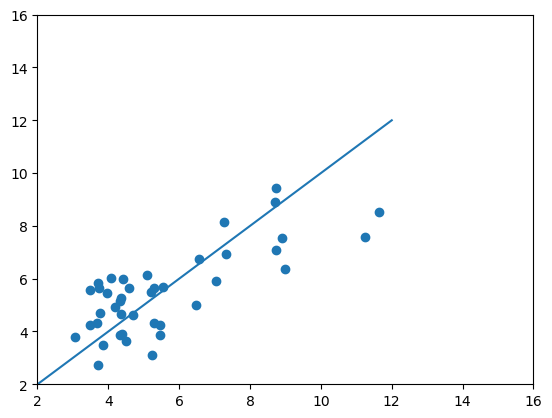

In [94]:
import matplotlib.pyplot as plt
predicted = best_dense_model.predict(X_test)
plt.scatter(y_test, predicted, marker="o")
plt.plot([0, 12], [0, 12])
plt.xlim(2, 16)
plt.ylim(2, 16)

In [96]:
best_dense_model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 9ms/step - loss: 2.4630 - mean_absolute_error: 1.2374


[2.4630446434020996, 1.2373734712600708]

In [ ]:
# https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html
def train_several_model(hp):
    choose_model = hp.Choice("choose_model", ["Heavy", "Light"])
    if choose_model == "Heavy":
        with hp.conditional_scope("choose_model", "Heavy"):
            model = build_model_1(hp)
    elif choose_model == "Light":
        with hp.conditional_scope("choose_model", "Light"):
            model = build_model_2(hp)
    else:
        raise ValueError('Unrecognized model_type')
    return model